<a href="https://colab.research.google.com/github/eldorjonneymatov/mdev_ds_pract/blob/main/final/final1_ticket_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aviachipta narxini bashorat qilish 

## Faoliyatni o\`rganish

**Loyiha maqsadi**: Hindiston davlatida 2019-yilning mart-iyun oylarida amalga oshirilgan ichki parvozlarga oid ma\`lumotlarga asosan chipta narxini bashorat qiluvchi model yaratish. Buning uchun mashinali o\`rgatishning supervised learning regressiya algoritmlaridan foydalaniladi.

## Kerakli modullarni yuklab olish va vizualizatsiya uchun ba\`zi parametrlarni o\`rnatish 

In [1]:
!pip install opendatasets
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import opendatasets as od
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline import backend_inline

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

In [4]:
backend_inline.set_matplotlib_formats('svg')
plt.rcParams['figure.figsize'] = [12, 12]
sns.set_style('darkgrid')

## Ma\`lumotlar bilan tanishish

In [5]:
od.download('https://www.kaggle.com/competitions/aviachipta-narxini-bashorat-qilish/data')
os.rename('aviachipta-narxini-bashorat-qilish', 'data')

100%|██████████| 382k/382k [00:00<00:00, 69.1MB/s]


Extracting archive ./aviachipta-narxini-bashorat-qilish/aviachipta-narxini-bashorat-qilish.zip to ./aviachipta-narxini-bashorat-qilish


In [6]:
data = pd.read_csv('data/train_data.csv')
df = data.copy(deep=True)
df

,id,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,1,Vistara,UK-810,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212
1,2,SpiceJet,SG-5094,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292
2,3,Vistara,UK-846,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553
3,4,Vistara,UK-706,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760
4,5,Indigo,6E-5394,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,Indigo,6E-6178,Bangalore,Night,one,Early_Morning,Mumbai,Economy,7.92,45,3153
19996,19997,AirAsia,I5-582,Kolkata,Morning,one,Afternoon,Delhi,Economy,5.83,24,3911
19997,19998,Vistara,UK-832,Chennai,Early_Morning,two_or_more,Evening,Bangalore,Economy,35.33,17,14822
19998,19999,Vistara,UK-996,Mumbai,Evening,one,Morning,Bangalore,Economy,16.33,21,6450


### Ustunlar tavsifi
* `ID`: Ketma - ketlik uchun qo'yilgan sonlar.
* `Airline`: Parvoz qilingan aviakompaniya nomi.
* `Flight`: Parvoz qilingan ID raqami.
* `Source_city`: Parvoz qaysi shahardan boshlanishi.
* `Departure_time`: Samolyotning ketish vaqti.
* `Stop`: Parvoz davomida to'xtashlar soni.
* `Arrival_time`: Qaytish vaqti.
* `Destination_city`: Qaysi davlatga parvoz qilinayotgani.
* `Class`: Foydalanuvchi samolyotning qaysi klass turidan foydalanib uchganligi.
* `Duration`: Parvoz davomiyligi.
* `Days_left`: Samolyotning qancha vaqtdan keyin qaytishi.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                20000 non-null  int64  
 1   airline           20000 non-null  object 
 2   flight            20000 non-null  object 
 3   source_city       20000 non-null  object 
 4   departure_time    20000 non-null  object 
 5   stops             20000 non-null  object 
 6   arrival_time      20000 non-null  object 
 7   destination_city  20000 non-null  object 
 8   class             20000 non-null  object 
 9   duration          20000 non-null  float64
 10  days_left         20000 non-null  int64  
 11  price             20000 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 1.8+ MB


Chipta narxining qancha bo\`lishi `id` - ketma-ketlikni ifodalovchi son va `flight` - parvoz raqamiga aloqador emas, shunga ko\`ra ushbu xususiyatlarni olib tashlaymiz.

In [8]:
class DropUnnecessaryFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features=['id', 'flight']):
        self.features = features
    def fit(self, X):
        return self
    def transform(self, X):
        if self.features:
            for f in self.features:
                X.drop(f, axis=1, inplace=True)
        return X
drop_features = DropUnnecessaryFeatures()
drop_features.fit_transform(df)

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,Vistara,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212
1,SpiceJet,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292
2,Vistara,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553
3,Vistara,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760
4,Indigo,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712
...,...,...,...,...,...,...,...,...,...,...
19995,Indigo,Bangalore,Night,one,Early_Morning,Mumbai,Economy,7.92,45,3153
19996,AirAsia,Kolkata,Morning,one,Afternoon,Delhi,Economy,5.83,24,3911
19997,Vistara,Chennai,Early_Morning,two_or_more,Evening,Bangalore,Economy,35.33,17,14822
19998,Vistara,Mumbai,Evening,one,Morning,Bangalore,Economy,16.33,21,6450


In [9]:
df.airline.value_counts()

Vistara      8535
Air_India    5371
Indigo       2924
GO_FIRST     1508
AirAsia      1056
SpiceJet      606
Name: airline, dtype: int64

In [10]:
df.source_city.value_counts()

Mumbai       4068
Delhi        4022
Bangalore    3486
Kolkata      3092
Hyderabad    2748
Chennai      2584
Name: source_city, dtype: int64

In [11]:
df.departure_time.value_counts()

Morning          4738
Early_Morning    4432
Evening          4341
Night            3231
Afternoon        3166
Late_Night         92
Name: departure_time, dtype: int64

In [12]:
df.stops.value_counts()

one            16666
zero            2440
two_or_more      894
Name: stops, dtype: int64

In [13]:
df.arrival_time.value_counts()

Night            6142
Evening          5316
Morning          4086
Afternoon        2536
Early_Morning    1004
Late_Night        916
Name: arrival_time, dtype: int64

In [14]:
df.destination_city.value_counts()

Mumbai       3918
Delhi        3825
Bangalore    3425
Kolkata      3323
Hyderabad    2814
Chennai      2695
Name: destination_city, dtype: int64

In [15]:
df['class'].value_counts()

Economy     13753
Business     6247
Name: class, dtype: int64

## Ma\`lumotlarni tahlil qilish

In [16]:
df.describe()

,duration,days_left,price
count,20000.000000,20000.000000,20000.000000
mean,12.177627,25.924150,20960.281700
std,7.157944,13.624874,22775.459535
min,0.830000,1.000000,1105.000000
25%,6.830000,14.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.080000,38.000000,42521.000000
max,38.580000,49.000000,114523.000000


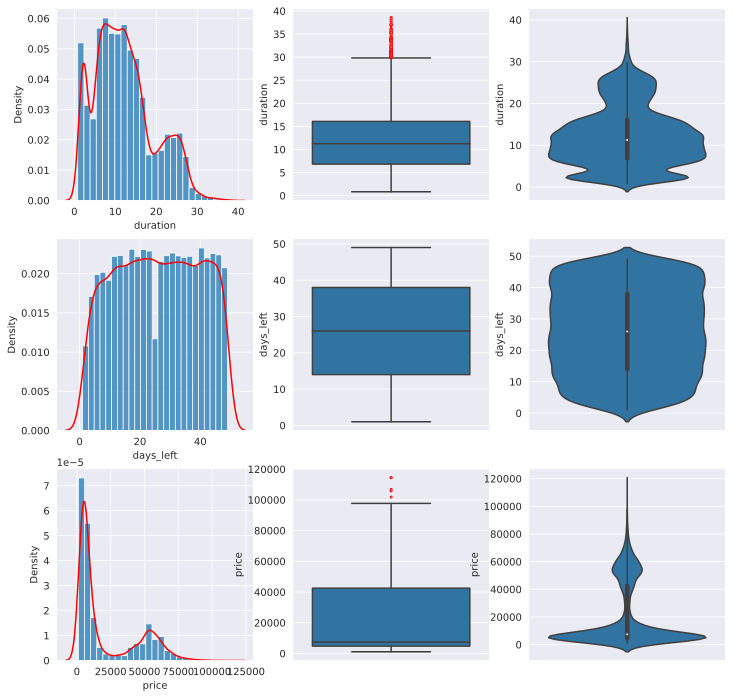

In [17]:
flierprops = dict(marker='o', markerfacecolor='w', markersize=2,
                  linestyle='none', markeredgecolor='r')
num_cols = ['duration', 'days_left', 'price']
inds = [[(0,0),(0,1),(0,2)],[(1,0),(1,1),(1,2)],[(2,0),(2,1),(2,2)]]
fig, ax = plt.subplots(3, 3)
for col, ind in zip(num_cols, inds):
    sns.histplot(ax=ax[ind[0]], data=df, x=col, bins=25, stat='density')
    sns.kdeplot(ax=ax[ind[0]], data=df, x=col, c='r')
    sns.boxplot(ax=ax[ind[1]], data=df, y=col, fliersize=2, flierprops = flierprops)
    sns.violinplot(ax=ax[ind[2]], data=df, y=col)

In [18]:
df[df.duration >= 30]

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
51,Air_India,Kolkata,Morning,one,Evening,Hyderabad,Economy,31.17,17,9560
54,Air_India,Chennai,Early_Morning,two_or_more,Afternoon,Kolkata,Economy,32.67,9,14265
125,Vistara,Delhi,Evening,one,Night,Mumbai,Business,30.00,3,70793
320,Vistara,Kolkata,Morning,two_or_more,Evening,Chennai,Economy,33.67,41,14939
369,Vistara,Delhi,Afternoon,two_or_more,Evening,Chennai,Economy,30.58,34,8282
...,...,...,...,...,...,...,...,...,...,...
19826,Vistara,Delhi,Afternoon,two_or_more,Evening,Chennai,Economy,30.58,27,7490
19888,Air_India,Hyderabad,Morning,two_or_more,Evening,Kolkata,Economy,30.25,15,10010
19905,Air_India,Bangalore,Evening,two_or_more,Early_Morning,Chennai,Economy,37.00,14,8644
19923,Air_India,Chennai,Early_Morning,one,Afternoon,Mumbai,Economy,32.92,16,9212


In [19]:
df[df.price >= 100000]

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
658,Vistara,Mumbai,Evening,one,Evening,Bangalore,Business,22.50,2,114523
1697,Vistara,Kolkata,Morning,one,Night,Delhi,Business,11.17,17,101780
4362,Vistara,Kolkata,Morning,one,Evening,Hyderabad,Business,9.50,4,106753
12397,Vistara,Chennai,Early_Morning,one,Afternoon,Mumbai,Business,7.08,5,105744
13085,Vistara,Delhi,Evening,two_or_more,Evening,Kolkata,Business,21.08,1,114434


In [20]:
df.corr()

,duration,days_left,price
duration,1.000000,-0.020091,0.213158
days_left,-0.020091,1.000000,-0.102545
price,0.213158,-0.102545,1.000000


## Ma\`lumotlarni mashinali o\`rgatish algoritmlari uchun uchun tayyorlash

In [21]:
class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self, features=['airline', 'source_city', 'departure_time', 'stops', 'arrival_time',
            'destination_city', 'class']):
        self.features = features
    def fit(self, X):
        return self
    def transform(self, X):
        encoder = OrdinalEncoder()
        if self.features:
            for f in self.features:
                X[f] = encoder.fit_transform(X[[f]])
        return X
encoder = Encoder()
df_encoded = df.copy(deep=True)
encoder.fit_transform(df_encoded)
df_encoded

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,5.0,0.0,1.0,0.0,5.0,5.0,1.0,14.25,21,7212
1,4.0,3.0,2.0,2.0,5.0,4.0,1.0,1.75,7,5292
2,5.0,0.0,4.0,0.0,2.0,2.0,0.0,9.58,5,60553
3,5.0,4.0,4.0,0.0,2.0,3.0,1.0,6.75,28,5760
4,3.0,1.0,1.0,2.0,4.0,5.0,1.0,2.00,4,10712
...,...,...,...,...,...,...,...,...,...,...
19995,3.0,0.0,5.0,0.0,1.0,5.0,1.0,7.92,45,3153
19996,0.0,4.0,4.0,0.0,0.0,2.0,1.0,5.83,24,3911
19997,5.0,1.0,1.0,1.0,2.0,0.0,1.0,35.33,17,14822
19998,5.0,5.0,2.0,0.0,4.0,0.0,1.0,16.33,21,6450


In [22]:
X = df_encoded.drop('price', axis=1)
y = df_encoded['price'].copy(deep=True)

In [23]:
means = X.mean()
stds = X.std()
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        return self
    def transform(self, X):
        return (X - means) / stds
scaler = Scaler()
X = scaler.fit_transform(X)

In [24]:
pipeline = Pipeline([
    ('dropper', DropUnnecessaryFeatures()),
    ('encoder', Encoder()),
    ('scaler', Scaler())
])

## Modellash 

In [25]:
split = StratifiedShuffleSplit(n_splits=12, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, X[['class']]):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid = X.iloc[test_index]
    y_valid = y.iloc[test_index]

In [26]:
def reg_report(y_pred, y_true):
    mae = mean_absolute_error(y_pred, y_true)
    rmse = np.sqrt(mean_squared_error(y_pred, y_true))
    print('mae:  ', mae)
    print('rmse: ', rmse)


### Multiple Regression

In [27]:
multiple_r = LinearRegression()
multiple_r.fit(X_train, y_train)
y_pred_mr = multiple_r.predict(X_valid)
reg_report(y_pred_mr, y_valid)

mae:   4656.546478922662
rmse:  7051.321316057758


##  DecisionTreeRegressor

In [28]:
tree_r = DecisionTreeRegressor(random_state=42)
tree_r.fit(X_train, y_train)
y_pred_dr = tree_r.predict(X_valid)
reg_report(y_pred_dr, y_valid)

mae:   2388.08
rmse:  5153.642215753825


### RandomForestRegressor

In [29]:
forest_r = RandomForestRegressor(n_estimators=200, random_state=42)
forest_r.fit(X_train, y_train)
y_pred_fr = forest_r.predict(X_valid)
reg_report(y_pred_fr, y_valid)

mae:   2012.4427800684525
rmse:  3777.62534413749


## AdaBoostRegressor

In [30]:
aboost_r2 = AdaBoostRegressor(forest_r)
aboost_r2.fit(X_train, y_train)
y_pred_ab2 = aboost_r2.predict(X_valid)
reg_report(y_pred_ab2, y_valid)

mae:   2212.4073490115384
rmse:  3936.882825148955


### XGBoost

In [31]:
xgb_r = XGBRegressor(n_estimators=450)
xgb_r.fit(X_train, y_train)
y_pred_xgb = xgb_r.predict(X_valid)
reg_report(y_pred_xgb, y_valid)

[06:52:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
mae:   2779.542913795471
rmse:  4544.849255036417


## Cross Validation

In [32]:
from sklearn.model_selection import cross_val_predict
y_pred_cv = cross_val_predict(forest_r, X=X, y=y, cv=10)
reg_report(y_pred_cv, y)

mae:   2006.412194510119
rmse:  3804.792341077703


### Grid Search 

In [33]:
param_grid = {'n_estimators': range(30,300,10)}
forest_gscv = GridSearchCV(forest_r, param_grid, cv=5)
forest_gscv.fit(X, y)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_estimators=200, random_state=42),
             param_grid={'n_estimators': range(30, 300, 10)})

In [34]:
pd.DataFrame(forest_gscv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,8.082270,0.039016,0.253431,0.005288,220,{'n_estimators': 220},0.971839,0.970211,0.971878,0.968845,0.970708,0.970696,0.001128,1
16,7.016768,0.035203,0.221961,0.005635,190,{'n_estimators': 190},0.971826,0.970150,0.971922,0.968804,0.970755,0.970691,0.001154,2
20,8.749899,0.510061,0.263404,0.004850,230,{'n_estimators': 230},0.971789,0.970226,0.971864,0.968854,0.970723,0.970691,0.001111,3
18,7.749693,0.043514,0.240966,0.002491,210,{'n_estimators': 210},0.971836,0.970160,0.971861,0.968879,0.970718,0.970691,0.001118,4
17,7.337195,0.035480,0.234559,0.006061,200,{'n_estimators': 200},0.971830,0.970085,0.971863,0.968836,0.970798,0.970682,0.001139,5
15,6.892774,0.526016,0.208713,0.003185,180,{'n_estimators': 180},0.971811,0.970092,0.971961,0.968791,0.970707,0.970672,0.001169,6
21,8.871319,0.079358,0.275655,0.003326,240,{'n_estimators': 240},0.971776,0.970200,0.971847,0.968839,0.970689,0.970670,0.001112,7
14,6.260887,0.049147,0.197147,0.001442,170,{'n_estimators': 170},0.971751,0.970095,0.971935,0.968836,0.970720,0.970667,0.001137,8
25,10.532474,0.502784,0.321596,0.005334,280,{'n_estimators': 280},0.971721,0.970156,0.971770,0.968894,0.970674,0.970643,0.001071,9
26,10.641305,0.067865,0.332816,0.003161,290,{'n_estimators': 290},0.971685,0.970132,0.971785,0.968916,0.970678,0.970639,0.001061,10


In [39]:
final_model = RandomForestRegressor(n_estimators=220, random_state=42)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_valid)
reg_report(y_pred, y_valid)

mae:   2011.0466524107142
rmse:  3776.80013801025


## Sinov to\`plami uchun narxlarni bashorat qilish

In [36]:
test_data = pd.read_csv('data/test_data.csv')
test_data = pipeline.fit_transform(test_data)

In [40]:
test_preds = final_model.predict(test_data)
solution = pd.DataFrame({'id':range(1,5001), 'price':test_preds})
solution.to_csv('solution.csv', index=False)